<a href="https://colab.research.google.com/github/liang-faan/python-ml/blob/main/SML_Quiz_Reference_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SML Quiz
**Instructions**

**Make a copy of this notebook.**

**Rename the notebook to *your_name - SML Quiz*.**

You may work in groups and ask me any questions.
You may also refer to the course materials, the internet and any resources you encounter. Discussions are welcomed, but you have to submit an individual answer notebook.

### This is your assessment project for this course.

You are given the following real estate transaction data.

Use all the tools that you have learnt in
1. Feature engineering
2. Data preprocessing
3. Model selection and evaluation
4. Performance tuning

to predict the price per sqm of the housing units.

### You need to do the following to pass this assessment:
#### Model Exploration
1. Perform a summary statistical analysis of the dataset and create hypothesis (wild guesses)
> Write your analysis in a text box after your codes.

#### Model Evaluation and Selection
1. Perform model selection on the base dataset
2. Include a linear regressor
3. Include a decision tree regressor
4. Include an ensemble model
5. Perform feature engineering, preprocessing, and fine-tuning so that you can improve your results. **Aim for MAPE of 5% or less.**
6. Report your results on the test data.
> Write your approach and any learning points/insights you have gathered during this development phase
>
> Write these in a text box after your codes


#### Model Explanation
1. Perform statistical and feature importance plots of a linear regression vs your chosen model
2. Contrast the difference in the important features computed by the linear regression vs your chosen model, which one makes more sense?
3. At the same time, explain the intuition between the chosen features and what goes on in a consumer's mind in reality.
> Write your analysis in a text box after each plot or after all the plots

#### Model saving for deployment
1. Save your model and use an f-string to automate today's date in the file name.

#### Additional tasks (not required for assessment)
> New ensemble methods: Stacking and Blending
>
> Conduct hyperparameter tuning
>
> Perform additional analysis.
>
> Create a dashboard or API environment in colab to test your predictive modelling service.

### Enable GPU acceleration

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [ ]:
# Check GPU
!nvidia-smi

Sat Apr  1 07:52:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Setup:
This set up script:

1. Checks to make sure that the GPU is RAPIDS compatible
1. Installs the **current stable version** of RAPIDSAI's core libraries using pip, which are:
  1. cuDF
  1. cuML
  1. cuGraph
  1. xgboost

**This will complete in about 3-4 minutes**

Please use the [RAPIDS Conda Colab Template notebook](https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9) if you need to install any of RAPIDS Extended libraries, such as:
- cuSpatial
- cuSignal
- cuxFilter
- cuCIM

OR
- nightly versions of any library


In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


In [ ]:
# The lightgbm version installed in colab is CPU
# We need to uninstall it first:
!pip3 uninstall lightgbm -y

# to re-install the GPU version
!pip3 install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

Found existing installation: lightgbm 3.3.5
Uninstalling lightgbm-3.3.5:
  Successfully uninstalled lightgbm-3.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Skipping wheel build for lightgbm, due to binaries being disabled for it.
  Running setup.py install for lightgbm ... done


### Solution starts here

In [ ]:
# Install the additional packages
!pip3 install ydata_profiling pycaret[full]

***Remember to restart runtime before continuing!***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from ydata_profiling import ProfileReport

In [ ]:
# Load data
data_path = Path('/content/drive/My Drive/pcml_data/5SML')
filename = 'housing_transactions.csv'

df = pd.read_csv(data_path / filename)

Explore your data

In [ ]:
# Use profiling for exploratory analysis
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Basic data cleaning and feature engineering

Some suggestions:
1. Date-type variables should be converted into something that measures the distance of time or numeric
> * year, month, day, weekday
>
> * number of days from a common reference date

2. Location variables should be properly considered in conjunction with the models that you think are going to be top choices.
> * use the postal_lat_lon.csv in the same folder

3. Freehold properties on average have a 20% higher selling price over leasehold properties, at new sale. Over time, this premium will fall to about 7% after 10 years. How do you separate freehold from leasehold?

4. Some transactions are enbloc or bulk purchases. Such transactions should not be included as they usually have a different consideration. How do you identify such transactions and drop them?

5. Landed properties are only restricted to residents and thus have a different consideration. How do you drop them?

In [ ]:
# Motivation to rename the columns (for wrangling purposes)
df['Unit Price ($ psm)']
df['price_psm']
df.price_psm

Project Name                           Address  No. of Units  \
0            THE BAYSHORE         22 Bayshore Road  #03-02              1   
1      KINGSFORD WATERBAY  66 Upper Serangoon View  #16-12              1   
2              THE JOVELL           13 Flora Drive  #02-11              1   
3            V ON SHENTON           5A Shenton Way  #44-12              1   
4              THE BEACON      130 Cantonment Road  #10-04              1   
...                   ...                               ...           ...   
46508               PRIVE         37 Punggol Field  #03-36              1   
46509          PARK GREEN        12 Rivervale Link  #17-21              1   
46510               PRIVE         37 Punggol Field  #09-35              1   
46511    EIGHT COURTYARDS        12 Canberra Drive  #11-24              1   
46512  BARTLEY RESIDENCES        3A Lorong How Sun  #09-19              1   

       Area (sqm) Type of Area  Transacted Price ($) Nett Price($)  \
0              88       Strata                888000             -   
1             102       Strata               1280000             -   
2              42       Strata                615000             -   
3             112       Strata               2855680       2847680   
4             103       Strata               1570000             -   
...           ...          ...                   ...           ...   
46508          77       Strata                828000             -   
46509         193       Strata               1470000             -   
46510          77       Strata                770000             -   
46511         106       Strata               1100000             -   
46512          99       Strata               1420000             -   

       Unit Price ($ psm)  Unit Price ($ psf)    Sale Date  \
0                   10091                 937  28-FEB-2019   
1                   12549                1166  28-FEB-2019   
2                   14643                1360  28-FEB-2019   
3                   25426                2362  28-FEB-2019   
4                   15243                1416  28-FEB-2019   
...                   ...                 ...          ...   
46508               10753                 999  01-AUG-2018   
46509                7617                 708  01-AUG-2018   
46510               10000                 929  01-AUG-2018   
46511               10377                 964  01-AUG-2018   
46512               14343                1333  01-AUG-2018   

               Property Type                  Tenure Completion Date  \
0                Condominium  99 Yrs From 31/05/1993            1996   
1                  Apartment  99 Yrs From 03/03/2014            2018   
2                Condominium  99 Yrs From 08/03/2018     Uncompleted   
3                  Apartment  99 Yrs From 29/11/2011            2017   
4                  Apartment  99 Yrs From 05/03/2004            2008   
...                      ...                     ...             ...   
46508  Executive Condominium  99 Yrs From 14/09/2010            2013   
46509  Executive Condominium  99 Yrs From 17/08/2001            2004   
46510  Executive Condominium  99 Yrs From 14/09/2010            2013   
46511            Condominium  99 Yrs From 20/09/2010            2014   
46512              Apartment  99 Yrs From 29/06/2011            2015   

      Type of Sale Purchaser Address Indicator  Postal District  \
0           Resale                     Private               16   
1         Sub Sale                     Private               19   
2         New Sale                         N.A               17   
3         New Sale                         N.A                1   
4           Resale                     Private                2   
...            ...                         ...              ...   
46508       Resale                         HDB               19   
46509       Resale                         HDB               19   
46510       Resale                

In [ ]:
# In python, we name features/variables using the area_sqm convention.
# In Java/Javascript, we name them using the CamelCase convention areaSqm
# Note that the CamelCase in Python is reserved for creating Classes (Objects)

# Create a data map using dictionary method
# Here, the original label is the key, and the new label is the value

label_rename_map = {
    'Project Name': 'project_name',
    'Address': 'address',
    'No. of Units': 'no_of_units',
    'Area (sqm)': 'area_sqm',
    'Type of Area': 'type_of_area',
    'Transacted Price ($)': 'transacted_price',
    'Nett Price($)': 'nett_price',
    'Unit Price ($ psm)': 'price_psm',
    'Unit Price ($ psf)': 'price_psf',
    'Sale Date': 'sale_date',
    'Property Type': 'property_type',
    'Tenure': 'tenure',
    'Completion Date': 'completion_date',
    'Type of Sale': 'type_of_sale',
    'Purchaser Address Indicator': 'purchaser_address_indicator',
    'Postal District': 'postal_district',
    'Postal Sector': 'postal_sector',
    'Postal Code': 'postal_code',
    'Planning Region': 'planning_region',
    'Planning Area': 'planning_area'
}

In [ ]:
# Apply the data map to change the label names of the dataframe
df.rename(label_rename_map, axis=1, inplace=True)

In [ ]:
# Check that the labels have been properly renamed
df.columns

Index(['project_name', 'address', 'no_of_units', 'area_sqm', 'type_of_area',
       'transacted_price', 'nett_price', 'price_psm', 'price_psf', 'sale_date',
       'property_type', 'tenure', 'completion_date', 'type_of_sale',
       'purchaser_address_indicator', 'postal_district', 'postal_sector',
       'postal_code', 'planning_region', 'planning_area'],
      dtype='object')

### Step 2: Data cleaning and feature creation

In [ ]:
# Enbloc and block purchases do not accurately reflect the price that most
# purchasers face, thus we should remove observations with no_of_units more than 1
df = df[df.no_of_units ==1]

In [ ]:
# Remove landed properties since their purchase is restricted to residents,
# while foreigners can still buy condominiums and apartments (non-landed).
df = df[df.property_type.isin(['Condominium', 'Apartment', 'Executive Condominium'])]

In [ ]:
# Remove Unknown in completion date and set the year to 2023 for Uncompleted
df = df[df.completion_date != 'Unknown']

In [ ]:
# All uncompleted units will have its year set to 2023
df['completion_date'] = df.completion_date.apply(
    lambda x: 2023 if not x[0].isdigit() else int(x))

In [ ]:
# Convert sale date to a proper datetime form
df['sale_date'] = df.sale_date.apply(pd.to_datetime)

In [ ]:
# (Optional for assessement)
# Create a reference date, where the earliest date in the dataset is 0 and each
# subsequent date increases by 1

# This will allow decision trees to group observations by dates in a very fine
# manner - Trend capturing.

# First get a de-duplicated list of sale date
# ## Then sort them
# ## Then create a incremental date using i += 1 for each consecutive date

dates = sorted(df.sale_date.drop_duplicates())

date_dict = {dt: idx for idx, dt in enumerate(dates)}

In [ ]:
# (Optional for assessement)
# Apply the date dictionary to the dataframe and call this date feature date_id.
df['date_id'] = df.sale_date.apply(lambda x: date_dict[x])

In [ ]:
df[['sale_date', 'date_id']]

sale_date  date_id
0     2019-02-28      666
1     2019-02-28      666
2     2019-02-28      666
3     2019-02-28      666
4     2019-02-28      666
...          ...      ...
46508 2018-08-01      456
46509 2018-08-01      456
46510 2018-08-01      456
46511 2018-08-01      456
46512 2018-08-01      456

[41738 rows x 2 columns]

In [ ]:
# Create leasehold/freehold dummy
# First, check what are the various tenures in the dataset
df.tenure.apply(lambda x: x.split(' ')[0]).value_counts()

99          29373
Freehold    11097
999           989
956           106
103            70
946            30
929            23
110            17
947            13
102             9
9999            6
89              3
N.A.            2
Name: tenure, dtype: int64

In [ ]:
# create leasehold dummy feature
def is_leasehold(tenure):
    tenure = tenure.split(' ')[0]
    if tenure in ('Freehold', 'N.A.'):
        return 0
    elif int(tenure) <= 99:
        return 1
    else:
        return 0

df['is_leasehold'] = df.tenure.apply(is_leasehold)

In [ ]:
# Merge lat/lon data to postal code
# First, read the postal code - lat/lon dataset
postal_lat_lon = pd.read_csv(data_path / 'postal_lat_lon.csv')

In [ ]:
# Merge lat lon to main dataset via postal codes
df = pd.merge(df, postal_lat_lon, on='postal_code', how='left')

In [ ]:
# Do a final check on the summary statistics
df.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Remove all observations without lat-lon
df.dropna(inplace=True)

### Step 3: Model Evaluation and Selection







In [ ]:
# Import Pycaret's regression module
from pycaret.regression import *

Features that we need to ignore:
1. No. of units - since all the values are 1 after cleaning.
2. Project Name - too unique and we already have lat lon.
3. Address - same as above.
4. Transacted Price - This is the answer, price_psf = transacted_price / area_sqm. Price is something we want to predict, so this feature cannot be inside.
5. Nett Price - same as above.
6. Price psm - choose either this or price_psf.
7. Tenure - we already used it to compute is_leasehold
8. Postal Code - we already used it to get lat lon.

Additional date features
PyCaret setup has an argument that will create year, month, day features for
dates. This argument is called date_features.

In [ ]:
df.columns

Index(['project_name', 'address', 'no_of_units', 'area_sqm', 'type_of_area',
       'transacted_price', 'nett_price', 'price_psm', 'price_psf', 'sale_date',
       'property_type', 'tenure', 'completion_date', 'type_of_sale',
       'purchaser_address_indicator', 'postal_district', 'postal_sector',
       'postal_code', 'planning_region', 'planning_area', 'date_id',
       'is_leasehold', 'lat', 'lon'],
      dtype='object')

In [ ]:
# Setup modeling run with PyCaret
model = setup(
    data=df,
    target='price_psf',
    normalize=True,
    date_features=['sale_date'],
    ignore_features=['project_name', 'address', 'no_of_units', 'transacted_price', 'nett_price', 'price_psm', 'tenure', 'postal_code']
)

### Step 4: Check which models perform the best

To check which models have GPU support, run models() with additional arguments like this:

`models(internal=True)[['Name', 'Turbo', 'GPU Enabled']]`

else this will work too:
`models()`

In [ ]:
# What are the models that are available?
models(internal=True)[['Name', 'Turbo', 'GPU Enabled']]

Name  Turbo  GPU Enabled
ID                                                             
lr                        Linear Regression   True        False
lasso                      Lasso Regression   True        False
ridge                      Ridge Regression   True        False
en                              Elastic Net   True        False
lar                  Least Angle Regression   True        False
llar           Lasso Least Angle Regression   True        False
omp             Orthogonal Matching Pursuit   True        False
br                           Bayesian Ridge   True        False
ard       Automatic Relevance Determination  False        False
par            Passive Aggressive Regressor   True        False
ransac              Random Sample Consensus  False        False
tr                       TheilSen Regressor  False        False
huber                       Huber Regressor   True        False
kr                             Kernel Ridge  False        False
svm               Support Vector Regression  False        False
knn                   K Neighbors Regressor   True        False
dt                  Decision Tree Regressor   True        False
rf                  Random Forest Regressor   True        False
et                    Extra Trees Regressor   True        False
ada                      AdaBoost Regressor   True        False
gbr             Gradient Boosting Regressor   True        False
mlp                           MLP Regressor  False        False
xgboost           Extreme Gradient Boosting   True        False
lightgbm    Light Gradient Boosting Machine   True        False
catboost                 CatBoost Regressor   True        False
dummy                       Dummy Regressor   True        False
Bagging                   Bagging Regressor   True        False
Stacking                 Stacking Regressor   True        False
Voting                     Voting Regressor   True        False

Use exclude or include to control what models will be trained.


```
compare_models(exclude=['tr', 'ransac', 'lar', 'huber', 'svm', 'et', 'ada'])

compare_models(include=['rf', 'xgboost', 'lightgbm', 'dt', 'br', 'lasso', 'catboost', 'knn', 'lr'])
```



In [ ]:
# Choose one of the above lines and code and execute here
compare_models(include=['rf', 'xgboost', 'lightgbm', 'dt', 'br', 'catboost', 'knn', 'lr'], sort='MAPE')

Processing:   0%|          | 0/37 [00:00<?, ?it/s]

LGBMRegressor(random_state=1655)

Let's now create a model with the best results.


In [ ]:
# Create a model object with the best model
best_model = create_model('lightgbm')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# We will also choose a few more models that perform well but not of the same class if possible.
ctb = create_model('catboost')
rf = create_model('rf')
knn = create_model('knn')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Stacking and Blending ensemble (Optional for Assessment - will cover during walkthrough)

Will a stacked model give better performance?

Stacking and blending works like this:
1. Blending blends multiple models and uses part of the validation data to train the next layer.
2. Stacking uses a model (meta-model) to select how much of each contributing model's results to rely on.
> Eg. we have a xgboost, catboost, and rf. Each of them predicts the results. This goes into the estimator_list argument.
>
> Then we choose a model (can be any models from lr to rf) and it will fit the
> predicted results to the actual results. This meta model will choose various weights on each of the first set of models that gives the best final accuracy. This goes into the meta_model argument.

In [ ]:
# Caution: This takes a long time to run even with a GPU.
# Note that the blended ensemble has better MAPE than our best model.

blended_model = blend_models(
    estimator_list = [best_model, ctb, knn],
    choose_better=True,
    optimize='MAPE')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Caution: This takes a long time to run even with a GPU.
# Note that the stacked ensemble has worse MAPE than
# both our best model and blended ensemble.

stacked_model = stack_models(
    estimator_list = [best_model, ctb, knn],
    meta_model = best_model,
    choose_better=True,
    optimize='MAPE')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Original model was better than the stacked model, hence it will be returned. NOTE: The display metrics are for the stacked model (not the original one).


### Test on unseen data
Always test the accuracy on the final test data (unseen data)!  

In [ ]:
# Use the test data to check predictive accuracy on unseen data
test_result = predict_model(best_model)

# Compute the MAPD for the selected model
mapd = np.median(abs(test_result.price_psf - test_result['prediction_label'])/test_result.price_psf)
print(f'The Median Absolute % Deviation is {mapd * 100:.2f}%.')

The Median Absolute % Deviation is 3.33%.


In [ ]:
# Use the test data to check predictive accuracy on unseen data
test_result = predict_model(blended_model)

# Compute the MAPD for the selected model
mapd = np.median(abs(test_result.price_psf - test_result['prediction_label'])/test_result.price_psf)
print(f'The Median Absolute % Deviation is {mapd * 100:.2f}%.')

The Median Absolute % Deviation is 3.40%.


### Additional analysis (Optional for Assessment - will cover during walkthrough)

We will always go with the best model when we don't have time constraints.

In [ ]:
# Ensure that the notebook can plot inline
%matplotlib inline

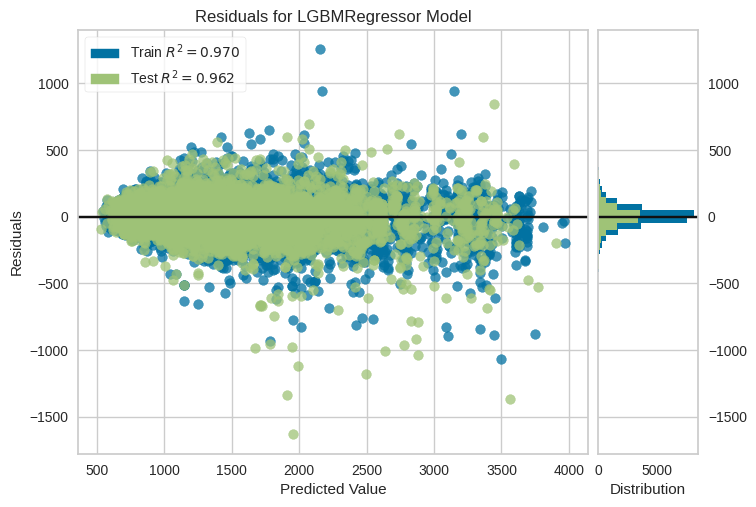

In [ ]:
# Residual plots
plot_model(best_model, plot='residuals')

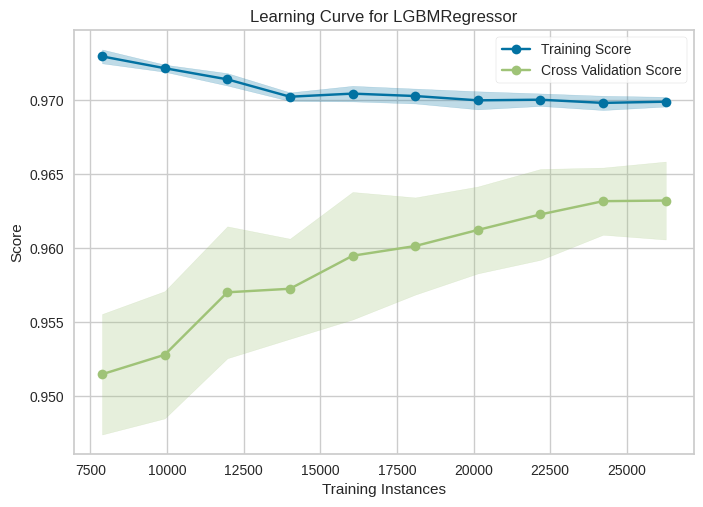

In [ ]:
# Learning curve
plot_model(best_model, plot='learning')

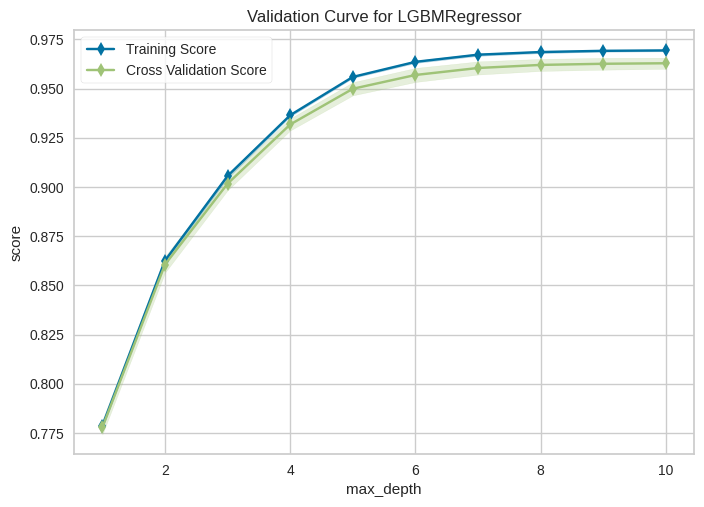

In [ ]:
# Validation curve
plot_model(best_model, plot='vc')

### Explain the model

After we have the best model, we need to explain why the model is accurate in order to convince human management that our results did not come from a black box.

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

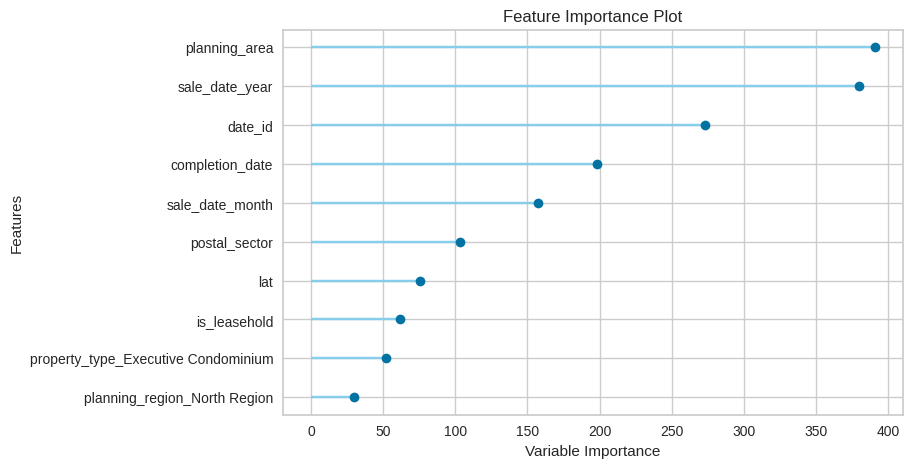

In [ ]:
# Create a linear regression model
lr = create_model('lr')

# Plot the feature importance of the linear regression
plot_model(lr, plot='feature')

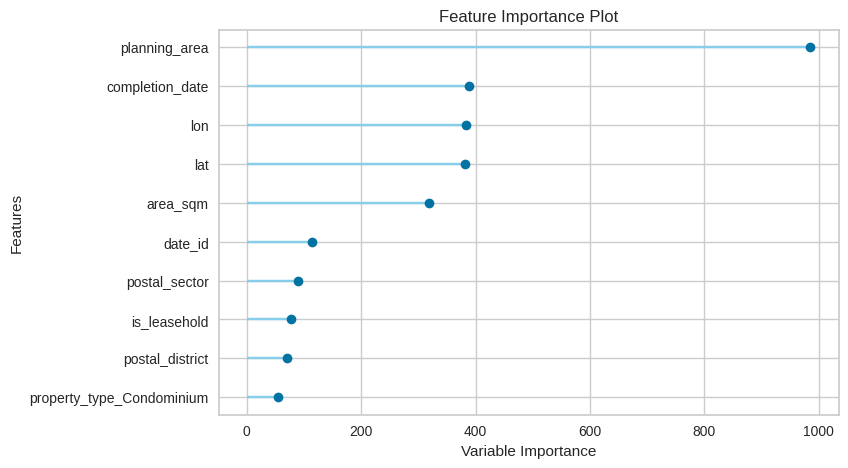

In [ ]:
# Compare the above feature importance plot with the best model you have chosen
plot_model(best_model, plot='feature')

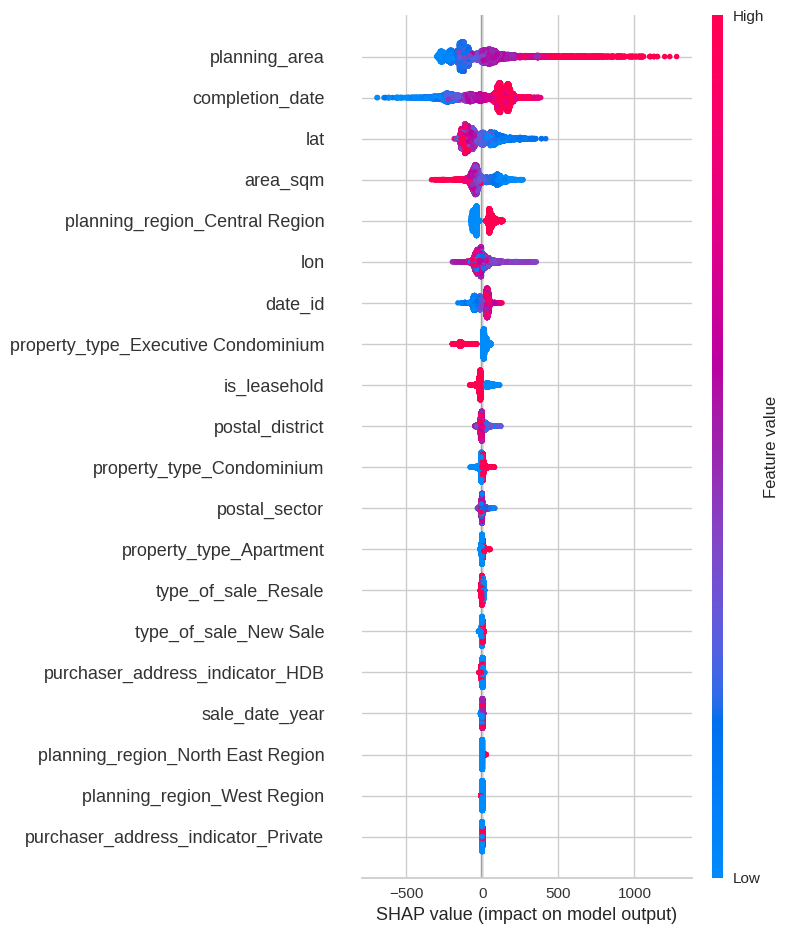

In [ ]:
# Plot a SHAP interpretation of the model
interpret_model(best_model)

### Hyperparameter Tuning (Optional for assessment - Will cover during walkthrough)
We can tune the model to squeeze a bit more accuracy out of the best model if we want.


In [ ]:
# Perform hyperparameter tuning (This will take a long time.)
# We managed to squeeze some performance out of the best model

tuned_model = tune_model(
    best_model,
    choose_better=True,
    search_library='optuna',
    n_iter=100,
    optimize='MAPE',
    early_stopping=True
)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-04-01 08:37:29,416] Searching the best hyperparameters using 29192 samples...
[I 2023-04-01 08:56:29,571] Finished hyperparemeter search!


### Finalize model

In [ ]:
# Retrain the model using 100% of the data
final_model = finalize_model(tuned_model)

### Save the model
We can save the trained model into a file, pass it to the software engineer to integrate into the solution.

In [ ]:
# Get today's date
from datetime import datetime

current_dt = datetime.now()

In [ ]:
# Save your chosen model using f-string with today's date
model_filepath = data_path / f'autovaluation_tuned_{current_dt}'
save_model(final_model, model_name=model_filepath)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['sale_date'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['area_sqm', 'completion_date',
                                              'postal_district', 'postal_sector',
                                              'date_id', 'is_leasehold', 'lat',
                                              'lon'],
                                     transformer=SimpleImputer())),
                 ('categ...
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('actual_estimator',
                  LGBMRegressor(bagging_fraction=0.8300316608455423,
                                bagging_freq=3,
                                feature_fraction=0.6663874561864729,
                                l

How do we use the model?

The model can spit out a high accuracy prediction using the features that it has been trained with.

Thus, we need to fit the model with the same features in order for it to generate a prediction.

### Test Model Deployment (Optional for Assessment - will cover during walkthrough)
There are 3 popular python webservices:
1. Django - Monolithic, very stable, but slower than the other 2. Slower is relative, it is still fast enough to support the most demanding workloads today.
2. Flask - Microservice, fast, super easy to code but not as stable in scaled production. We use this for quick testing.
3. FastAPI - My weapon of choice. Its very fast (even faster than node.js) and stable under scaled production.

My recommendation if you want to learn about webservice:
1. Start with Django. This will give you the proper foundation and also, Django is the oldest out of the 3 and extremely well-supported by the community. The components in Django are most complete.
2. After that, learn FastAPI. FastAPI is very easy to code but its data support layer is not as easy as Django. Personally, I use Django to manage the data communication within my webservice and FastAPI to focus on serving the frontend.

For API testing in Jupyter, we have a convenient package called flask-ngrok, which we will use in this section. It will create a webservice from your jupyter notebook.

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
!tar -xvf /content/ngrok-stable-linux-amd64.tgz
!./ngrok authtoken 29BoQQA0pxkkwLIjnQuDu8POt1S_6qzo9qu6utp4D1V7uofch

--2023-04-01 09:49:54--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13856790 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz’

ngrok-stable-linux- 100%[===================>]  13.21M  8.37MB/s    in 1.6s    

2023-04-01 09:49:56 (8.37 MB/s) - ‘ngrok-stable-linux-amd64.tgz’ saved [13856790/13856790]

ngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!pip3 install -U flask flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load the model as your software engineer would.
from pycaret.regression import *

model_filepath = '/content/drive/My Drive/pcml_data/5SML/autovaluation_tuned_2023-04-01 08:59:16.322366'
latest_model = load_model(model_filepath)

Transformation Pipeline and Model Successfully Loaded


The codes below creates a webserver with your model loaded.

A webserver once started (line 20: app.run()) will remain active and 'listen' for requests.
> Since we are sending data inputs to the models for a prediction, and the inputs can be very long or sensitve, we use a POST request.
>
> See line 14 below. The data input to the webserver is retrieved by request.get_json, which converts json into python dictionary.
>
> We then create a pandas dataframe from the python dictionary in line 15.
>
> Then we feed this input into the pycaret model for scoring, using the function predict_model(). This is line 16.
>
> The results is then returned to the webserver, which will send this back to the user.

In [ ]:
import os
import pandas as pd
from pycaret.regression import *

from flask_ngrok import run_with_ngrok
from flask import Flask, request

app = Flask(__name__)
run_with_ngrok(app)

@app.route('/', methods=['GET', 'POST'])
def scoring():
    if request.method == 'POST':
        data = request.get_json(silent=True)
        df = pd.DataFrame([data])
        df['sale_date'] = df.sale_date.apply(pd.to_datetime)
        predicted_value = predict_model(latest_model, data=df)
        return f"The predicted value for this property is S${predicted_value['prediction_label'].iloc[0]:.2f}."
    else:
        return f"Please use a POST method."

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-30:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/usr/local/lib/python3.9/dist-packages/urllib3/util/connection.py", line 95, in create_connection
    raise err
  File "/usr/local/lib/python3.9/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/usr/local/lib/python3.9/dist-packages/ur

After you run the previous cell, we will need to send user request to the link given above by ngrok. See the line that says Running on http://xxx.ngrok.io.

> Note that this url will change everytime you re-run the cell.
>
> This is the url that you send a user request to, and it will return you a response.

Now go to https://reqbin.com/. This is a API testing tool where we can create a
POST request, send it to the ngrok.io url above, and check the response.
> In the box that says http://google.com, paste the ngrok.io generated by the cell above.
>
> In the next box, choose POST.
>
> In the tabs below, click Content, and we insert a json input in blank space below. Cut and paste the sample input below and click Send. You can change the values to whatever you like.

```
{
    "sale_date": "2021-09-11",
    "area_sqm": 106,
    "completion_date": 2014,
    "date_id": 456,
    "is_leasehold": 0,
    "lat": 1.438962789,
    "lon": 103.831365,
    "planning_area": "Yishun",
    "planning_region": "North Region",
    "postal_district": 27,
    "postal_sector": 76,
    "property_type": "Condominium",
    "purchaser_address_indicator": "Private",
    "type_of_area": "Strata",
    "type_of_sale": "Resale"
}
```
The response is shown in the next box. It should say something like
> "The predicted value for this property is S$914.39."
